In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from scipy.optimize import linear_sum_assignment
from cellpose import plot, utils
import lap

In [1]:
pip install cellpose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 13.2 MB/s eta 0:00:00


In [2]:
pip install lap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lap: filename=lap-0.4.0-cp310-cp310-linux_x86_64.whl size=1628966 sha256=1d04e8155a7adebf35a186df3552c75170f6a3d2ba5eb73bfa64e7dd65156721
  Stored in directory: /root/.cache/pip/wheels/00/42/2e/9dfe19270eea279d79e84767ff0d7b8082c3bf776cad00e83d
Successfully built lap


In [4]:
dat = np.load('/1_seg.npy', allow_pickle=True).item()

# plot image with outlines overlaid in red
outlines = utils.outlines_list(dat['masks'])

## Data manipulation

### 1. centralize cell outlines

In [5]:
mean_mat = [np.mean(outlines[i], axis=0) for i in range(len(outlines))]

In [6]:
outlines_st = []
for i in range(len(outlines)):
    temp = outlines[i]
    temp_st = np.transpose(np.vstack((temp[:,0] - mean_mat[i][0], temp[:,1] - mean_mat[i][1])))
    outlines_st.append(temp_st)

### 2. plot single cells

In [7]:
def image_single_cell(centralized_outlines, plot = False):
    min_coords = np.min(centralized_outlines, axis=0)
    max_coords = np.max(centralized_outlines, axis=0)
    image_size = max_coords - min_coords + 1

    # Create an empty image with all zeros
    image = np.zeros((int(image_size[1]), int(image_size[0])), dtype=np.uint8)

    # Set the outline points to 1 in the image
    # Adjust the points to fit in the image coordinate system
    for point in centralized_outlines:
        image_x = int(point[0] - min_coords[0])
        image_y = int(point[1] - min_coords[1])
        image[image_y, image_x] = 1

    # Display the resulting image
    if plot:
        plt.imshow(image, cmap='gray')
        plt.title('Centralized Cell Outline')
        plt.show()

    return image

In [8]:
def image_side_by_side(image_0, image_1, title_0 = "Cell 0", title_1 = "Cell 1"):
    # Plot the images side by side
    plt.figure(figsize=(10, 5))

    # Plotting image_0
    plt.subplot(1, 2, 1)
    plt.imshow(image_0, cmap='gray')
    plt.title(title_0)
    plt.axis('off')  # to turn off the axis for this subplot

    # Plotting image_1
    plt.subplot(1, 2, 2)
    plt.imshow(image_1, cmap='gray')
    plt.title(title_1)
    plt.axis('off')  # to turn off the axis for this subplot

## Shape Similarity

### 1. Introduction to Hu Moments

#### Central Moments
The central moments for an image function $f(x, y)$ (which, in the context of image processing, is typically the pixel intensity at coordinates $(x, y)$ ) are defined as:
$$
\mu_{p q}=\sum_x \sum_y(x-\bar{x})^p(y-\bar{y})^q f(x, y)
$$
where $\bar{x}$ and $\bar{y}$ are the coordinates of the centroid of the image (or shape), and $p$ and $q$ are the orders of the moment. The centroid coordinates are given by:
$$
\begin{aligned}
& \bar{x}=\frac{m_{10}}{m_{00}} \\
& \bar{y}=\frac{m_{01}}{m_{00}}
\end{aligned}
$$

Here, $m_{p q}$ are the raw moments defined as:
$$
m_{p q}=\sum_x \sum_y x^p y^q f(x, y)
$$

#### Hu Moments

Derived from these central moments, Hu introduced seven moments (in his 1962 paper) which are invariant to image transformations:

1. $H_1=\eta_{20}+\eta_{02}$
2. $H_2=\left(\eta_{20}-\eta_{02}\right)^2+4 \eta_{11}^2$
3. $H_3=\left(\eta_{30}-3 \eta_{12}\right)^2+\left(3 \eta_{21}-\eta_{03}\right)^2$
4. $H_4=\left(\eta_{30}+\eta_{12}\right)^2+\left(\eta_{21}+\eta_{03}\right)^2$
5. $H_5=\left(\eta_{30}-3 \eta_{12}\right)\left(\eta_{30}+\eta_{12}\right)\left[\left(\eta_{30}+\eta_{12}\right)^2-3\left(\eta_{21}+\eta_{03}\right)^2\right]+\left(3 \eta_{21}-\right.$ $\left.\eta_{03}\right)\left(\eta_{21}+\eta_{03}\right)\left[3\left(\eta_{30}+\eta_{12}\right)^2-\left(\eta_{21}+\eta_{03}\right)^2\right]$
6. $H_6=\left(\eta_{20}-\eta_{02}\right)\left[\left(\eta_{30}+\eta_{12}\right)^2-\left(\eta_{21}+\eta_{03}\right)^2\right]+4 \eta_{11}\left(\eta_{30}+\eta_{12}\right)\left(\eta_{21}+\eta_{03}\right)$
7. $H_7=\left(3 \eta_{21}-\eta_{03}\right)\left(\eta_{30}+\eta_{12}\right)\left[\left(\eta_{30}+\eta_{12}\right)^2-3\left(\eta_{21}+\eta_{03}\right)^2\right]-\left(\eta_{30}-\right.$ $\left.3 \eta_{12}\right)\left(\eta_{21}+\eta_{03}\right)\left[3\left(\eta_{30}+\eta_{12}\right)^2-\left(\eta_{21}+\eta_{03}\right)^2\right]$

In these formulas, $\eta_{p q}$ are the normalized central moments, defined as:
$$
\eta_{p q}=\frac{\mu_{p q}}{\mu_{00}^{\left(1+\frac{p+q}{2}\right)}}
$$

These seven Hu Moments provide a compact but effective representation of a shape, and are widely used in pattern recognition and image analysis due to their invariance properties.

### 2. Shape similarity based on Hu moments

The 'matchShapes' function in OpenCV compares two shapes $S_1$ and $S_2$ by computing their $\mathrm{Hu}$ Moments $H_1$ and $H_2$ respectively. The similarity between these shapes is then calculated using one of the following methods:
1. Method I1 (default):
$$
D\left(S_1, S_2\right)=\sum_{i=1}^7\left|\frac{1}{\operatorname{sign}\left(h_{1 i}\right) \log \left|h_{1 i}\right|}-\frac{1}{\operatorname{sign}\left(h_{2 i}\right) \log \left|h_{2 i}\right|}\right|
$$
2. Method I2 (alternative method):
$$
D\left(S_1, S_2\right)=\sum_{i=1}^7|\log | h_{1 i}|-\log | h_{2 i}||
$$
3. Method I3 (another alternative):
$$
D\left(S_1, S_2\right)=\sum_{i=1}^7 \frac{\left|h_{1 i}-h_{2 i}\right|}{\left|h_{1 i}\right|}
$$

Here, $h_{1 i}$ and $h_{2 i}$ are the ith Hu Moments of shapes $S_1$ and $S_2$ respectively.

A lower value of $D$ indicates higher similarity.

In [9]:
def shape_similarity(image_0, image_1, print_output = True):
    # Find contours for each image
    contours_0, _ = cv2.findContours(image_0, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_1, _ = cv2.findContours(image_1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming each image contains one main cell to compare
    cnt0 = contours_0[0]
    cnt1 = contours_1[0]

    # Compare the shapes
    shape_similarity = cv2.matchShapes(cnt0, cnt1, cv2.CONTOURS_MATCH_I1, 0.0)

    if print_output:
        print("Shape Similarity:", shape_similarity)
    else:
        return(shape_similarity)

## Cell tracking with Shape similarity

#### 1. Generate second image by adding random noise

In [10]:
np.random.seed(1)

cell_image_1 = mean_mat
cell_image_2 = [eachrow + np.random.normal(0, 10, eachrow.shape) for eachrow in mean_mat]

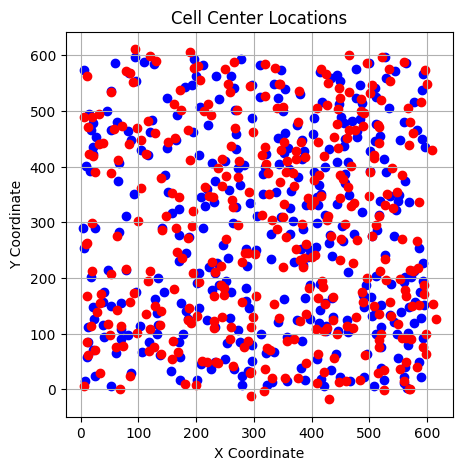

In [11]:
x_coords = [point[0] for point in cell_image_1]
y_coords = [point[1] for point in cell_image_1]

x_coords_r = [point[0] for point in cell_image_2]
y_coords_r = [point[1] for point in cell_image_2]

# Plotting
plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
plt.scatter(x_coords, y_coords, color='blue', marker='o')  # You can change the color and marker style
plt.scatter(x_coords_r, y_coords_r, color='red', marker='o')  # You can change the color and marker style
plt.title('Cell Center Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

#### 2. LAP tracking with cell center only

In [12]:
def calculate_cost_matrix_with_center(cells_image1, cells_image2):
    # This function should calculate the cost matrix based on your chosen criteria
    # For simplicity, let's assume Euclidean distance between cell centers
    n = len(cells_image1)
    cost_matrix = np.zeros((n, n))

    for i, cell1 in enumerate(cells_image1):
        for j, cell2 in enumerate(cells_image2):
            # Example cost: Euclidean distance between cell centers
            cost_matrix[i, j] = np.linalg.norm(cell1 - cell2)

    return cost_matrix

In [13]:
# Calculate the cost matrix
cost_matrix = calculate_cost_matrix_with_center(cell_image_1, cell_image_2)

# Solve the Linear Assignment Problem
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# row_ind and col_ind are arrays of indices indicating the optimal assignment
for r, c in zip(row_ind[1:5], col_ind[1:5]):
    print(f"Cell {r} in image 1 is matched to Cell {c} in image 2")

Cell 1 in image 1 is matched to Cell 1 in image 2
Cell 2 in image 1 is matched to Cell 2 in image 2
Cell 3 in image 1 is matched to Cell 3 in image 2
Cell 4 in image 1 is matched to Cell 4 in image 2


In [14]:
correct_rate = sum([1 if row_ind[ri] == col_ind[ri] else 0 for ri in range(len(row_ind))]) / len(row_ind)
print("Correct rate for LAP matching with only cell center is", round(correct_rate, 3))

Correct rate for LAP matching with only cell center is 0.833


#### 3. LAP tracking with both cell center and shape similary used

In [15]:
def calculate_cost_matrix_with_center_and_shape(cells_center_image1, cells_center_image2, outlines_st):
    # This function should calculate the cost matrix based on your chosen criteria
    # For simplicity, let's assume Euclidean distance between cell centers
    n = len(cells_center_image1)
    cost_matrix = np.zeros((n, n))

    for i, cell1 in enumerate(cells_center_image1):
        for j, cell2 in enumerate(cells_center_image2):
            image_0 = image_single_cell(outlines_st[i])
            image_1 = image_single_cell(outlines_st[j])
            # Example cost: Euclidean distance between cell centers + shape similarity
            cost_matrix[i, j] = np.linalg.norm(cell1 - cell2) + 100*shape_similarity(image_0, image_1, print_output = False)

    return cost_matrix

In [16]:
# Calculate the cost matrix
cost_matrix = calculate_cost_matrix_with_center_and_shape(cell_image_1, cell_image_2, outlines_st)

# Solve the Linear Assignment Problem
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# row_ind and col_ind are arrays of indices indicating the optimal assignment
for r, c in zip(row_ind[1:5], col_ind[1:5]):
    print(f"Cell {r} in image 1 is matched to Cell {c} in image 2")

Cell 1 in image 1 is matched to Cell 1 in image 2
Cell 2 in image 1 is matched to Cell 2 in image 2
Cell 3 in image 1 is matched to Cell 3 in image 2
Cell 4 in image 1 is matched to Cell 4 in image 2


In [17]:
correct_rate = sum([1 if row_ind[ri] == col_ind[ri] else 0 for ri in range(len(row_ind))]) / len(row_ind)
print("Correct rate for LAP matching with cell center and shape is", round(correct_rate, 3))

Correct rate for LAP matching with cell center and shape is 1.0


With the shape similarity added, the correct rate for LAP tracking is improved from $83.3\%$ to $100\%$

Next, we could

1. try different ways to calculate the shape similarity. Hu-similarity is just a starting point. It could make mistakes, see shape similarity between cell 0 vs 1 and cell 0 vs 2.
2. The cost matrix needs neighbor constrains. That is, we don't need to caculate the cost when two cells are far away from each other.
3. More penalty term could be added in the loss function. For example, the direction of the long axis of the ellipse could be a potential direction that the cell moves to in the next time frame.


## Real Data analysis

In [58]:
# List of file paths
file_paths = ['/1_seg.npy', '/2_seg.npy', '/3_seg.npy', '/4_seg.npy', '/5_seg.npy', '/6_seg.npy','/7_seg.npy', '/8_seg.npy', '/9_seg.npy', '/10_seg.npy', '/11_seg.npy', '/12_seg.npy','/13_seg.npy', '/14_seg.npy', '/15_seg.npy',
'/16_seg.npy', '/17_seg.npy', '/18_seg.npy', '/19_seg.npy', '/20_seg.npy']

# Initialize a list to store the outlines
outlines_list = []

# Loop through each file path, load the data, and get the outlines
for file_path in file_paths:
    data = np.load(file_path, allow_pickle=True).item()
    outlines = utils.outlines_list(data['masks'])
    outlines_list.append(outlines)

# Now outlines_list[0] corresponds to outlines, outlines_list[1] to outlines2, and so on.


In [59]:
def calculate_outlines(outlines):
    mean_mat = [np.mean(outlines[i], axis=0) for i in range(len(outlines))]
    outlines_st = []
    for i in range(len(outlines)):
       temp = outlines[i]
       temp_st = np.transpose(np.vstack((temp[:,0] - mean_mat[i][0], temp[:,1] - mean_mat[i][1])))
       outlines_st.append(temp_st)
    return outlines_st

In [60]:
outlines_st_all = []
for i in range(20):
  outlines_st_all.append(calculate_outlines(outlines_list[i]))

image_all=[]
for i in range(20):
  image_all.append(image_single_cell(outlines_st_all[i][0]))

### 1.Tracking For Real Data

input parameters

In [61]:
check_index=3

In [62]:
def calculate_cell_center(outlines):
    mean_mat = [np.mean(outlines[i], axis=0) for i in range(len(outlines))]
    return mean_mat

cell_center = []
for i in range(20):
  cell_center.append(calculate_cell_center(outlines_list[i]))


In [63]:
def calculate_cost_matrix_with_center_nm(cells_image1, cells_image2):
    # This function should calculate the cost matrix based on your chosen criteria
    # For simplicity, let's assume Euclidean distance between cell centers
    n = len(cells_image1)
    m= len(cells_image2)

    cost_matrix_small = np.full((n, m),np.inf)
    cost_matrix = np.full((n+m, n+m),np.inf)
    for i, cell1 in enumerate(cells_image1):
        for j, cell2 in enumerate(cells_image2):
            # Example cost: Euclidean distance between cell centers
            cost_matrix[i, j] = np.linalg.norm(cell1 - cell2)
            cost_matrix_small[i, j] = np.linalg.norm(cell1 - cell2)
    C_alt=1.05*np.max(cost_matrix_small)
    C_lower_right=np.min(np.transpose(cost_matrix_small))
    for i, cell1 in enumerate(cells_image1):
        for j, cell2 in enumerate(cells_image2):
            cost_matrix[i, i+m] = 15
            cost_matrix[j+n, j] = 15
            cost_matrix[j+n, i+m] = C_lower_right
    return cost_matrix

In [64]:
def plot_tracking_center(outlines_list, cell_center, check_index, row_ind):
    # Calculate the cost matrix
    cost_matrix = calculate_cost_matrix_with_center_nm(cell_center[check_index], cell_center[check_index+1])

    # Solve the Linear Assignment Problem

    _, row_ind, col_ind= lap.lapjv(cost_matrix)

    plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
    n=len(cell_center[check_index])
    for o in outlines_list[check_index]:
        plt.plot(o[:, 0], o[:, 1], color='b')
    for o in outlines_list[check_index + 1]:
        plt.plot(o[:, 0], o[:, 1], color='r')

    x_coords = [point[0] for point in cell_center[check_index]]
    y_coords = [point[1] for point in cell_center[check_index]]

    x_coords_r = [point[0] for point in cell_center[check_index + 1]]
    y_coords_r = [point[1] for point in cell_center[check_index + 1]]

    plt.scatter(x_coords, y_coords, color='blue', marker='o', s=20)
    plt.scatter(x_coords_r, y_coords_r, color='red', marker='o', s=20)

    for i in range(n):
        if row_ind[i] <= n:
            plt.plot([x_coords[i], x_coords_r[row_ind[i]]], [y_coords[i], y_coords_r[row_ind[i]]], 'g', linewidth=1)

    plt.title('Cell Center Locations between frame 1 and frame 2')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()


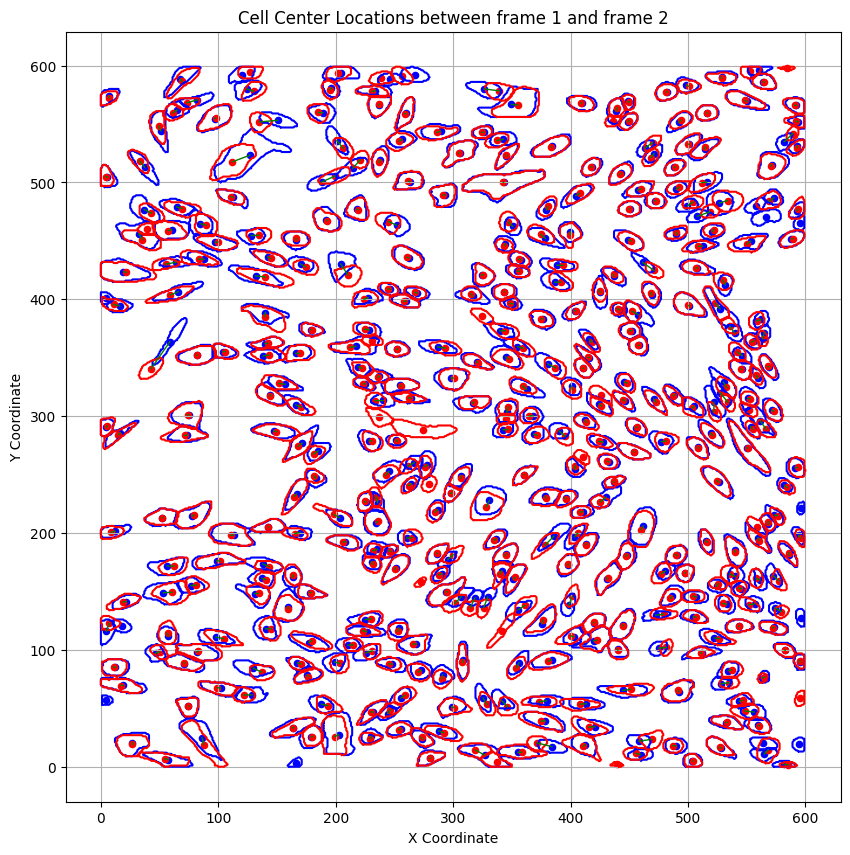

In [65]:
plot_tracking_center(outlines_list, cell_center, check_index, row_ind)

## 2.Combine shape similarity

In [66]:
def calculate_cost_matrix_with_center_and_shape_all(cells_image1, cells_image2, outlines_st_1,outlines_st_2, weight):
    # This function should calculate the cost matrix based on your chosen criteria
    # For simplicity, let's assume Euclidean distance between cell centers
    n = len(cells_image1)
    m= len(cells_image2)
    cost_matrix_small = np.full((n, m),np.inf)
    cost_matrix = np.full((n+m, n+m),np.inf)
    for i, cell1 in enumerate(cells_image1):
        for j, cell2 in enumerate(cells_image2):
            image_0 = image_single_cell(outlines_st_1[i])
            image_1 = image_single_cell(outlines_st_2[j])
            # Example cost: Euclidean distance between cell centers
            cost_matrix[i, j] = np.linalg.norm(cell1 - cell2)+(1-weight)*shape_similarity(image_0, image_1, print_output = False)*100
            cost_matrix_small[i, j] = np.linalg.norm(cell1 - cell2)+(1-weight)*shape_similarity(image_0, image_1, print_output = False)*100
    C_alt=1.05*np.max(cost_matrix_small)
    C_lower_right=np.min(np.transpose(cost_matrix_small))
    for i, cell1 in enumerate(cells_image1):
        for j, cell2 in enumerate(cells_image2):
            cost_matrix[i, i+m] = 20
            cost_matrix[j+n, j] = 20
            cost_matrix[j+n, i+m] = C_lower_right
    return cost_matrix


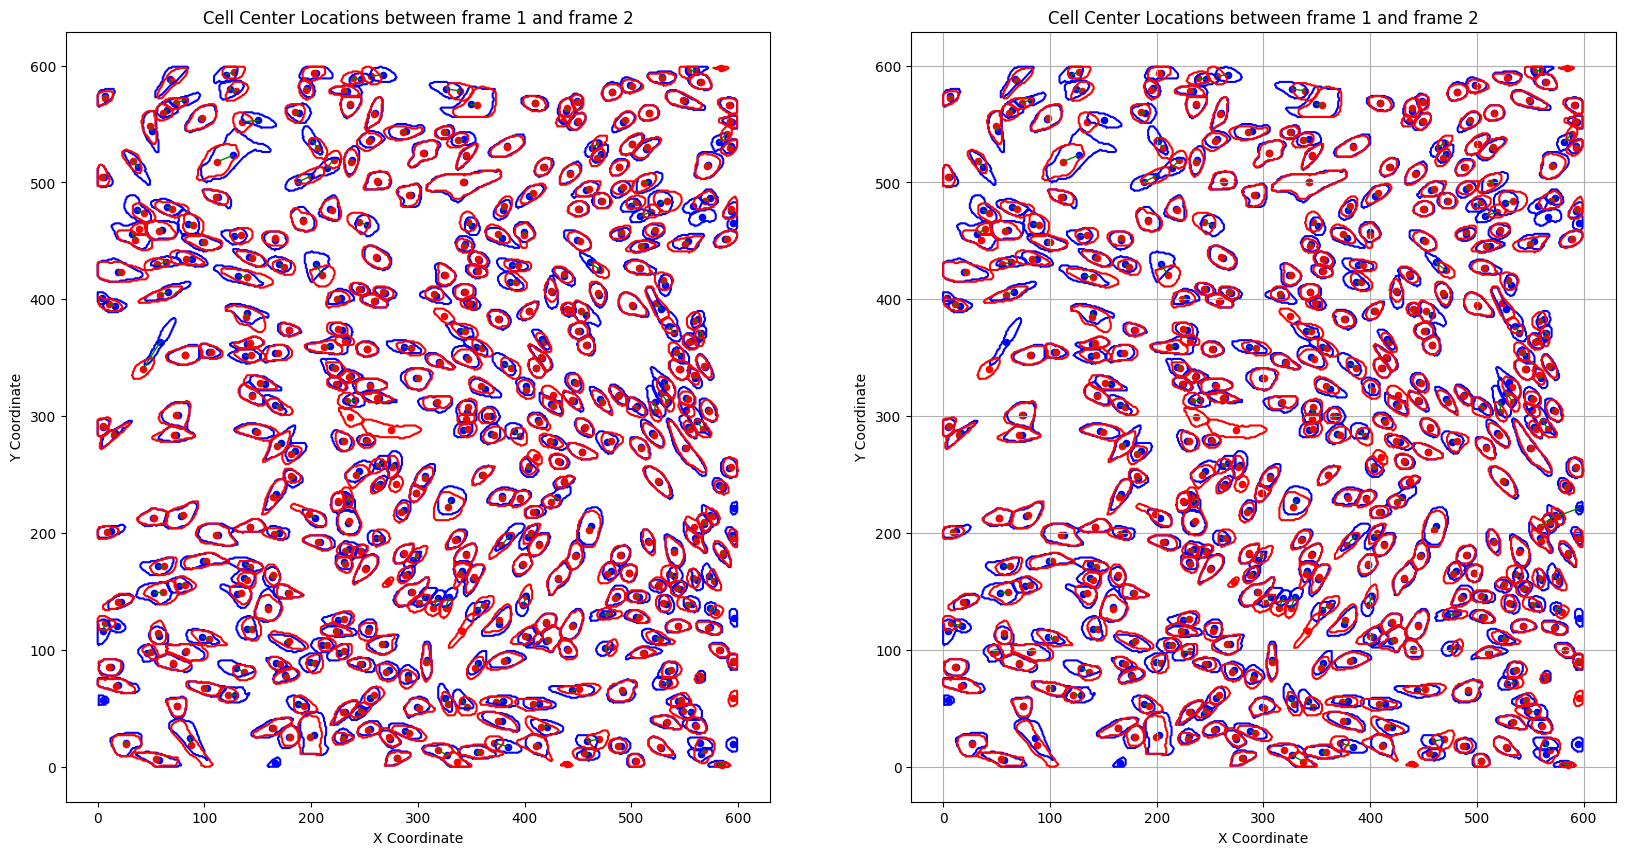

In [71]:
cost_matrix = calculate_cost_matrix_with_center_nm(cell_center[check_index], cell_center[check_index+1])
_, row_ind, col_ind= lap.lapjv(cost_matrix)

cost_matrix= calculate_cost_matrix_with_center_and_shape_all(cell_center[check_index], cell_center[check_index+1],outlines_st_all[check_index],outlines_st_all[check_index+1],0.7)
# Solve the Linear Assignment Problem
_, row_ind2, col_ind2= lap.lapjv(cost_matrix)

# Plotting
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed

n=len(cell_center[check_index])
m=len(cell_center[check_index+1])
n2=n
m2=m
plt.subplot(1, 2, 1)

for o in outlines_list[check_index]:
    plt.plot(o[:,0], o[:,1], color='b')
for o in outlines_list[check_index+1]:
    plt.plot(o[:,0], o[:,1], color='r')

x_coords = [point[0] for point in cell_center[check_index]]
y_coords = [point[1] for point in cell_center[check_index]]


x_coords_r = [point[0] for point in cell_center[check_index+1]]
y_coords_r = [point[1] for point in cell_center[check_index+1]]





plt.scatter(x_coords, y_coords, color='blue', marker='o',s=20)  # You can change the color and marker style
plt.scatter(x_coords_r, y_coords_r, color='red', marker='o',s=20)  # You can change the color and marker style



for i in range(n):
   if row_ind[i]<=m:
    plt.plot([x_coords[i],x_coords_r[row_ind[i]]], [y_coords[i],y_coords_r[row_ind[i]]], 'g',linewidth=1)

plt.title('Cell Center Locations between frame 1 and frame 2')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')


plt.subplot(1, 2, 2)

for o in outlines_list[check_index]:
    plt.plot(o[:,0], o[:,1], color='b')
for o in outlines_list[check_index+1]:
    plt.plot(o[:,0], o[:,1], color='r')

x_coords = [point[0] for point in cell_center[check_index]]
y_coords = [point[1] for point in cell_center[check_index]]


x_coords_r = [point[0] for point in cell_center[check_index+1]]
y_coords_r = [point[1] for point in cell_center[check_index+1]]




plt.scatter(x_coords, y_coords, color='blue', marker='o',s=20)  # You can change the color and marker style
plt.scatter(x_coords_r, y_coords_r, color='red', marker='o',s=20)  # You can change the color and marker style



for i in range(n2):
   if row_ind2[i]<=m2:
    plt.plot([x_coords[i],x_coords_r[row_ind2[i]]], [y_coords[i],y_coords_r[row_ind2[i]]], 'g',linewidth=1)

plt.title('Cell Center Locations between frame 1 and frame 2')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

## 3. Store the Dataset in csv file

In [26]:
matched_index_all=[]
for i in range(19):
  check_index=i
  n=len(outlines_list[check_index])
  m=len(outlines_list[check_index+1])
  cost_matrix = calculate_cost_matrix_with_center_nm(cell_center[check_index], cell_center[check_index+1])
  _, row_ind, col_ind= lap.lapjv(cost_matrix)
  row_ind=row_ind[:n]
  #row_ind = pd.Series(row_ind, dtype=pd.Int64Dtype())
  row_ind=np.array(row_ind,dtype=float)
  row_ind[row_ind >= m] = np.nan
  array = np.arange(n)
  array=np.array(array,dtype=float)
  matched_index_all.append(array)
  matched_index_all.append(row_ind)

In [27]:
matches_1_2 = pd.DataFrame({'Frame_1': matched_index_all[0], 'Frame_2': matched_index_all[1]})
matches_2_3 = pd.DataFrame({'Frame_2': matched_index_all[2], 'Frame_3': matched_index_all[3]})
matches_3_4 = pd.DataFrame({'Frame_3': matched_index_all[4], 'Frame_4': matched_index_all[5]})
matches_4_5 = pd.DataFrame({'Frame_4': matched_index_all[6], 'Frame_5': matched_index_all[7]})
matches_5_6 = pd.DataFrame({'Frame_5': matched_index_all[8], 'Frame_6': matched_index_all[9]})
matches_6_7 = pd.DataFrame({'Frame_6': matched_index_all[10], 'Frame_7': matched_index_all[11]})
matches_7_8 = pd.DataFrame({'Frame_7': matched_index_all[12], 'Frame_8': matched_index_all[13]})
matches_8_9 = pd.DataFrame({'Frame_8': matched_index_all[14], 'Frame_9': matched_index_all[15]})
matches_9_10 = pd.DataFrame({'Frame_9': matched_index_all[16], 'Frame_10': matched_index_all[17]})
matches_10_11 = pd.DataFrame({'Frame_10': matched_index_all[18], 'Frame_11': matched_index_all[19]})
matches_11_12 = pd.DataFrame({'Frame_11': matched_index_all[20], 'Frame_12': matched_index_all[21]})
matches_12_13 = pd.DataFrame({'Frame_12': matched_index_all[22], 'Frame_13': matched_index_all[23]})
matches_13_14 = pd.DataFrame({'Frame_13': matched_index_all[24], 'Frame_14': matched_index_all[25]})
matches_14_15 = pd.DataFrame({'Frame_14': matched_index_all[26], 'Frame_15': matched_index_all[27]})
matches_15_16 = pd.DataFrame({'Frame_15': matched_index_all[28], 'Frame_16': matched_index_all[29]})
matches_16_17 = pd.DataFrame({'Frame_16': matched_index_all[30], 'Frame_17': matched_index_all[31]})
matches_17_18 = pd.DataFrame({'Frame_17': matched_index_all[32], 'Frame_18': matched_index_all[33]})
matches_18_19 = pd.DataFrame({'Frame_18': matched_index_all[34], 'Frame_19': matched_index_all[35]})
matches_19_20 = pd.DataFrame({'Frame_19': matched_index_all[36], 'Frame_20': matched_index_all[37]})



# Initialize an empty DataFrame
df = pd.DataFrame(columns=['Frame_1', 'Frame_2', 'Frame_3', 'Frame_4', 'Frame_5', 'Frame_6', 'Frame_7', 'Frame_8', 'Frame_9', 'Frame_10', 'Frame_11', 'Frame_12','Frame_13', 'Frame_14', 'Frame_15', 'Frame_16',
                           'Frame_17', 'Frame_18','Frame_19', 'Frame_20'])

# Process matching data frame by frame
for frame in range(1, 20):
    current_match = eval(f'matches_{frame}_{frame + 1}')

    # Get all cell indices for the current and next frame
    current_cells = set(current_match[f'Frame_{frame}'])
    next_cells = set(current_match[f'Frame_{frame + 1}'])

    # Update the DataFrame
    for cell in current_cells:
        # If this cell appears for the first time in the current frame
        if not (sum(df[f'Frame_{frame}'] == cell) >= 1):
            new_row = pd.DataFrame([{f'Frame_{i}': np.nan for i in range(1, 21)}])
            new_row[f'Frame_{frame}'] = cell
            df = pd.concat([df, new_row], ignore_index=True)

        # Update the match
        matched_cell = float(current_match[current_match[f'Frame_{frame}'] == cell][f'Frame_{frame + 1}'].values[0])   # find the cell line
        df.loc[df[f'Frame_{frame}'] == cell, f'Frame_{frame + 1}'] = matched_cell

    # Handle newly appeared cells
    #for cell in next_cells:
    #    if cell not in df[f'Frame_{frame + 1}'].values:
    #       new_row = pd.DataFrame([{f'Frame_{i}': np.nan for i in range(1, 21)}])
    #       new_row[f'Frame_{frame + 1}'] = cell
    #      df = pd.concat([df, new_row], ignore_index=True)
matched_index=df
matched_index

,Frame_1,Frame_2,Frame_3,Frame_4,Frame_5,Frame_6,Frame_7,Frame_8,Frame_9,Frame_10,Frame_11,Frame_12,Frame_13,Frame_14,Frame_15,Frame_16,Frame_17,Frame_18,Frame_19,Frame_20
0,0.0,5.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,6.0,8.0,9.0,10.0,10.0,7.0,6.0,7.0,8.0,0.0,0.0
1,1.0,1.0,2.0,2.0,10.0,6.0,14.0,10.0,11.0,12.0,10.0,13.0,16.0,14.0,16.0,14.0,15.0,17.0,21.0,25.0
2,2.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,3.0,4.0,3.0,4.0,2.0,7.0,6.0,7.0,8.0,7.0,7.0,9.0,7.0,6.0,4.0,4.0,5.0,6.0,5.0
4,4.0,4.0,5.0,4.0,5.0,5.0,8.0,11.0,12.0,13.0,12.0,19.0,25.0,26.0,26.0,24.0,23.0,25.0,22.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,194.0,194.0
618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,227.0,230.0
619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.0,NaN
620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.0,313.0


In [28]:
# ... (assuming matched_index and outlines_list have been defined as earlier) ...

# Create empty lists to hold the expanded data
frames = []
cell_indices = []
x_coords = []
y_coords = []

# Process each frame
for frame_number in range(1, 20 + 1):  # This ensures we only go up to frame 6
    # Get the matched indices for the current frame from the matched_index DataFrame
    matched_indices_for_frame = matched_index[f'Frame_{frame_number}'].dropna()

    # Iterate over each outline and its new index
    for cell_index, new_index in enumerate(matched_indices_for_frame.index, start=0):
        outline = outlines_list[frame_number - 1][cell_index]  # Retrieve the correct outline using the original index
        for coord_pair in outline:
            # Append the data to the lists
            frames.append(frame_number)
            cell_indices.append(new_index + 1)  # Add 1 because enumerate starts at 1
            x_coords.append(coord_pair[0])
            y_coords.append(coord_pair[1])

# Create a DataFrame with the expanded lists
df = pd.DataFrame({
    'Frame': frames,
    'Cell Index': cell_indices,
    'X': x_coords,
    'Y': y_coords
})

# Display the DataFrame to confirm its structure
print(df)

# Save the DataFrame to a CSV file
csv_file_path = 'cell_data_with_boundaries.csv'
df.to_csv(csv_file_path, index=False)

print(f"CSV file has been saved at {csv_file_path}")



        Frame  Cell Index    X    Y
0           1           1   48    0
1           1           1   47    1
2           1           1   46    1
3           1           1   45    1
4           1           1   44    2
...       ...         ...  ...  ...
410864     20         622  102  563
410865     20         622  101  563
410866     20         622  100  563
410867     20         622   99  563
410868     20         622   98  563

[410869 rows x 4 columns]
CSV file has been saved at cell_data_with_boundaries.csv


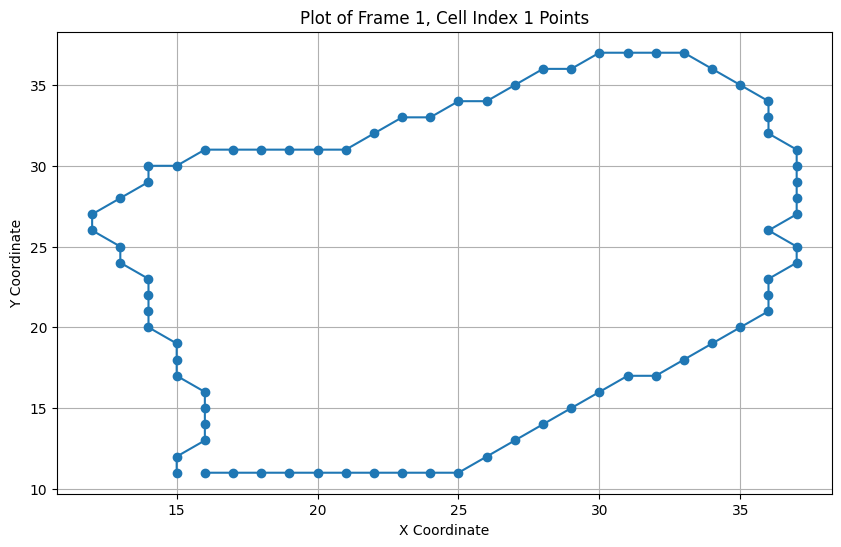

In [34]:
# Filter the DataFrame for rows where 'Frame' is 1 and 'Cell Index' is 1.
filtered_df = df[(df['Frame'] == 2) & (df['Cell Index'] == 20)]

# Now, let's plot the filtered points.
plt.figure(figsize=(10, 6))  # Set the figure size as needed.
plt.plot(filtered_df['X'], filtered_df['Y'], marker='o')  # Plot with markers at each point.
plt.title('Plot of Frame 1, Cell Index 1 Points')  # Set the title of the plot.
plt.xlabel('X Coordinate')  # Set the label for the x-axis.
plt.ylabel('Y Coordinate')  # Set the label for the y-axis.
plt.grid(True)  # Enable the grid for better readability.
plt.show()  # Display the plot.

### 4.Plot the boundary of a particular cell over the entire time period

In [35]:
def compute_cell_index_entire(cell_center,start_check_index, cell_index, n):
    cell_index_entire = [None] * (n + 1)
    # Initialize the first element with the initial cell index
    cell_index_entire[0] = cell_index

    current_index = cell_index  # Start with the initial cell index

    for i in range(n):
        current_check_index = start_check_index + i
        next_check_index = current_check_index + 1

        if next_check_index < len(cell_center):
            # Calculate cost matrix for current and next time point
            cost_matrix = calculate_cost_matrix_with_center_nm(
                cell_center[current_check_index], cell_center[next_check_index]
            )
            # Solve the LAP
            _, row_ind, _ = lap.lapjv(cost_matrix)

            # Update the current index based on the LAP results
            current_index = row_ind[current_index] if current_index < len(row_ind) else -1
            cell_index_entire[i + 1] = current_index

    return cell_index_entire


In [33]:
cell_index_entire_all=[]
for i in range(5):
  cell_index_entire_all.append(compute_cell_index_entire(cell_center,0,i,5))

In [36]:
cell_index_entire_all

[[0, 5, 0, 0, 0, 3],
 [1, 1, 2, 2, 10, 6],
 [2, 2, 3, 394, 3, 8],
 [3, 3, 4, 3, 4, 2],
 [4, 4, 5, 4, 5, 5]]

In [37]:
def plot_boundary_multiple(cell_center,outlines_list,check_index, cell_index_entire, n):
    plt.figure(figsize=(20, 10))  # Adjust the figure size as needed

    for i in range(n):
        current_check_index = check_index + i
        if current_check_index < len(outlines_list) - 1:  # Check if next index is within bounds
            # Get cell indices for current and next time points
            cell_index = cell_index_entire[i]
            next_cell_index = cell_index_entire[i + 1]

            # Current cell boundary and center
            cell = outlines_list[current_check_index][cell_index]
            x_coords = cell_center[current_check_index][cell_index][0]
            y_coords = cell_center[current_check_index][cell_index][1]
            plt.plot(cell[:, 0], cell[:, 1])
            plt.scatter(x_coords, y_coords,marker='o', s=20)

            # Next cell boundary and center
            if next_cell_index < len(outlines_list[current_check_index + 1]):
                cell_next = outlines_list[current_check_index + 1][next_cell_index]
                x_coords_r = cell_center[current_check_index + 1][next_cell_index][0]
                y_coords_r = cell_center[current_check_index + 1][next_cell_index][1]
                plt.plot(cell_next[:, 0], cell_next[:, 1])
                plt.scatter(x_coords_r, y_coords_r,marker='o', s=20)

                # Plot tracking line
                plt.plot([x_coords, x_coords_r], [y_coords, y_coords_r], linewidth=1)

    plt.title('Plot the boundary of a particular cell over multiple time points')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()


In [38]:
def plot_boundary_multiple_time(cell_center,outlines_list,check_index, cell_index_entire, n):
    # Set up a figure with n subplots arranged in a row
    fig, axes = plt.subplots(1, n, figsize=(20, 10))  # Adjust the figure size as needed

    for i in range(n):
        ax = axes[i]  # Get the current subplot
        current_check_index = check_index + i
        if current_check_index < len(outlines_list):  # Check if next index is within bounds
            # Get cell indices for current and next time points
            cell_index = cell_index_entire[i]
            # Current cell boundary and center
            cell = outlines_list[current_check_index][cell_index]
            x_coords = cell_center[current_check_index][cell_index][0]
            y_coords = cell_center[current_check_index][cell_index][1]
            ax.plot(cell[:, 0], cell[:, 1])
            ax.scatter(x_coords, y_coords, marker='o', s=20)

            ax.set_title(f'Time Point {i + 1}')
            ax.set_xlabel('X Coordinate')
            ax.set_ylabel('Y Coordinate')
            ax.grid(True)

    plt.tight_layout()
    plt.show()

In [40]:
from PIL import Image
# List of file paths
file_paths = ['/1.png', '/2.png', '/3.png', '/4.png', '/5.png', '/6.png']

real_image_list = []

for file_path in file_paths:
    real_image = Image.open(file_path)
    real_image_list.append(real_image)

image_matrices = [np.array(image) for image in real_image_list]

Combine these two plots

In [41]:
def process_and_overlay_images(image_matrices, outlines_list, cell_center, cell_index_entire, check_index, n):
    # Step 1: Get bounding rectangles
    bounding_rectangles = []
    for i in range(n):
        current_check_index = check_index + i
        if current_check_index < len(outlines_list):
            cell_index = cell_index_entire[current_check_index]
            cell_boundary = outlines_list[current_check_index][cell_index]
            min_x = min(cell_boundary[:, 0]) - 1
            max_x = max(cell_boundary[:, 0]) + 1
            min_y = min(cell_boundary[:, 1]) - 1
            max_y = max(cell_boundary[:, 1]) + 1
            bounding_rectangles.append((min_x, min_y, max_x, max_y))

    # Step 2: Crop images
    cropped_images = []
    for image_matrix, (min_x, min_y, max_x, max_y) in zip(image_matrices, bounding_rectangles):
        min_x, min_y, max_x, max_y = map(int, [min_x, min_y, max_x, max_y])
        min_x = max(min_x, 0)
        min_y = max(min_y, 0)
        max_x = min(max_x, image_matrix.shape[1])
        max_y = min(max_y, image_matrix.shape[0])
        cropped_image = image_matrix[min_y:max_y, min_x:max_x]
        cropped_images.append(cropped_image)

    # Step 3: Overlay boundaries
    fig, axes = plt.subplots(1, n, figsize=(20, 10))
    for i in range(n):
        ax = axes[i]
        current_check_index = check_index + i

        if current_check_index < len(outlines_list):
            cropped_image = cropped_images[i]
            ax.imshow(cropped_image, cmap='gray')

            cell_index = cell_index_entire[current_check_index]
            cell_boundary = outlines_list[current_check_index][cell_index]
            cell_center_coords = cell_center[current_check_index][cell_index]

            bounding_box = bounding_rectangles[i]
            shifted_boundary_x = cell_boundary[:, 0] - bounding_box[0] - 1
            shifted_boundary_y = cell_boundary[:, 1] - bounding_box[1] - 1
            shifted_center_x = cell_center_coords[0] - bounding_box[0] - 1
            shifted_center_y = cell_center_coords[1] - bounding_box[1] - 1

            ax.plot(shifted_boundary_x, shifted_boundary_y, color='red')
            ax.scatter(shifted_center_x, shifted_center_y, color='red', marker='o', s=20)

            ax.set_title(f'Time Point {current_check_index + 1}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()
    return bounding_rectangles


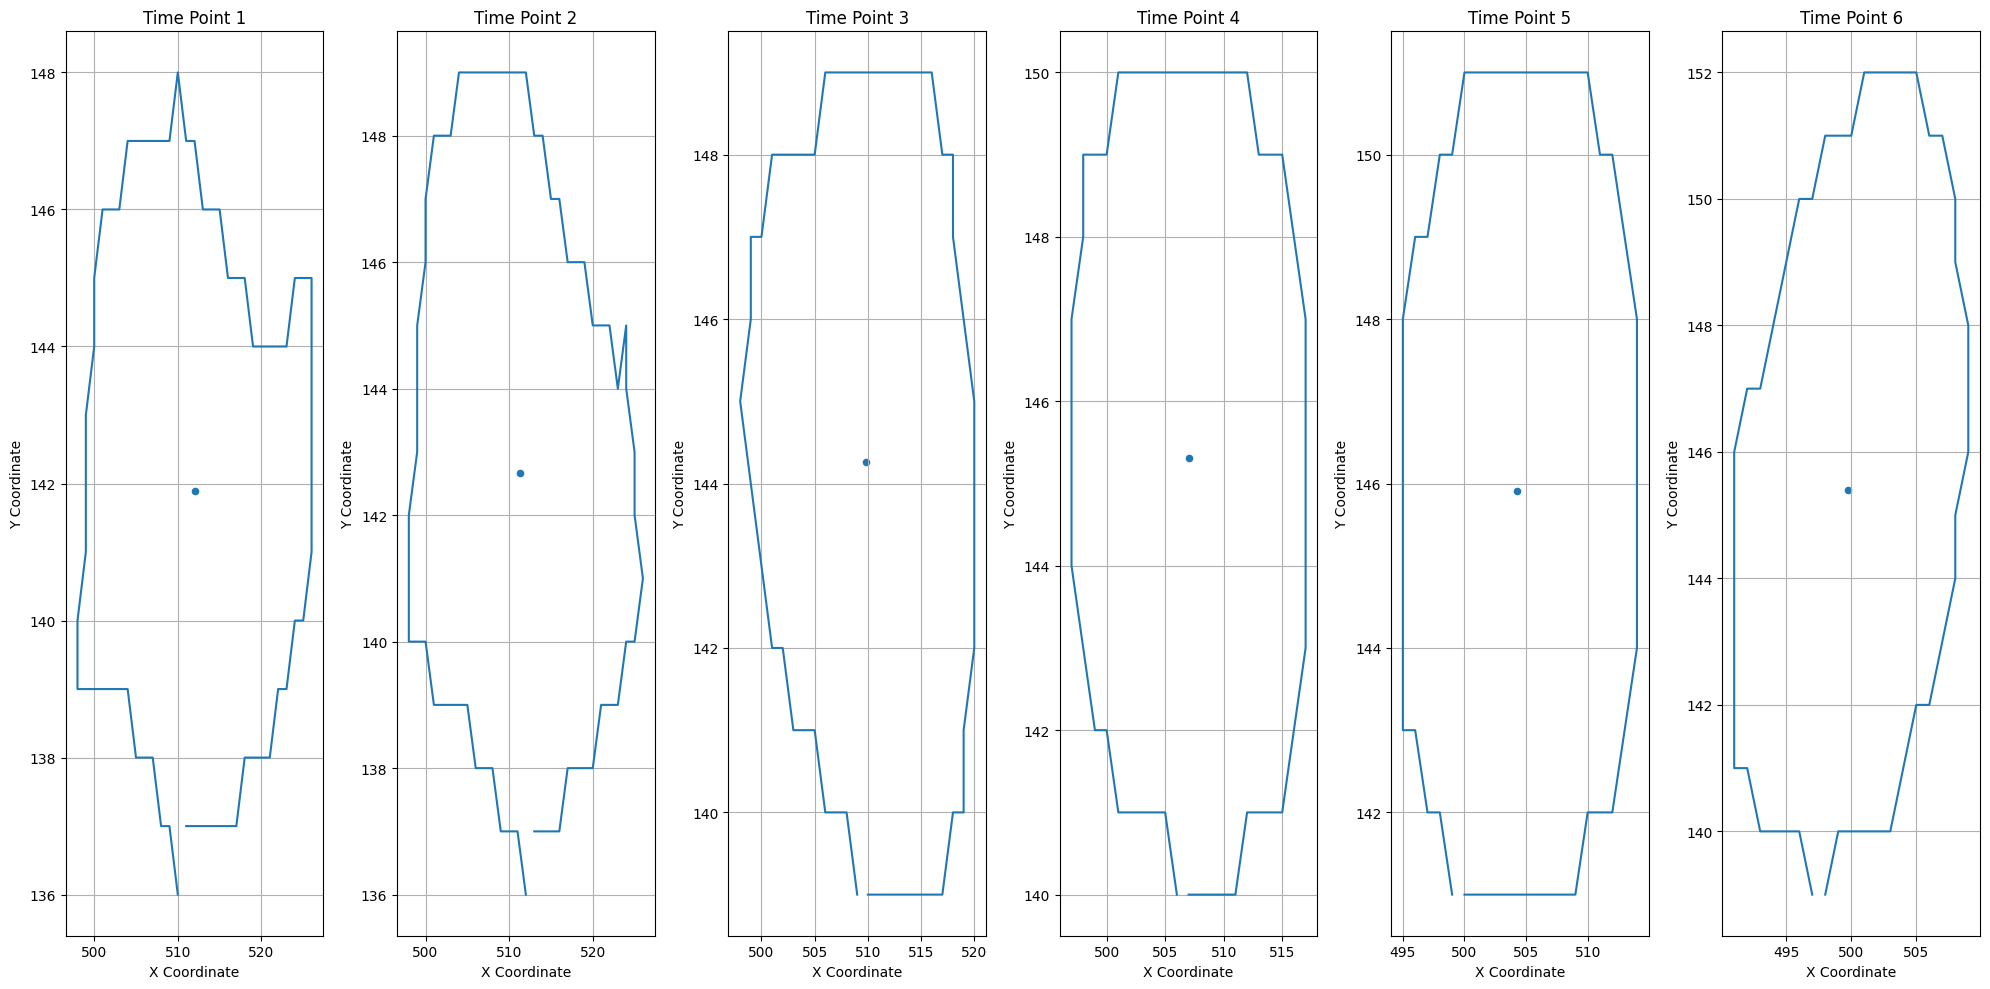

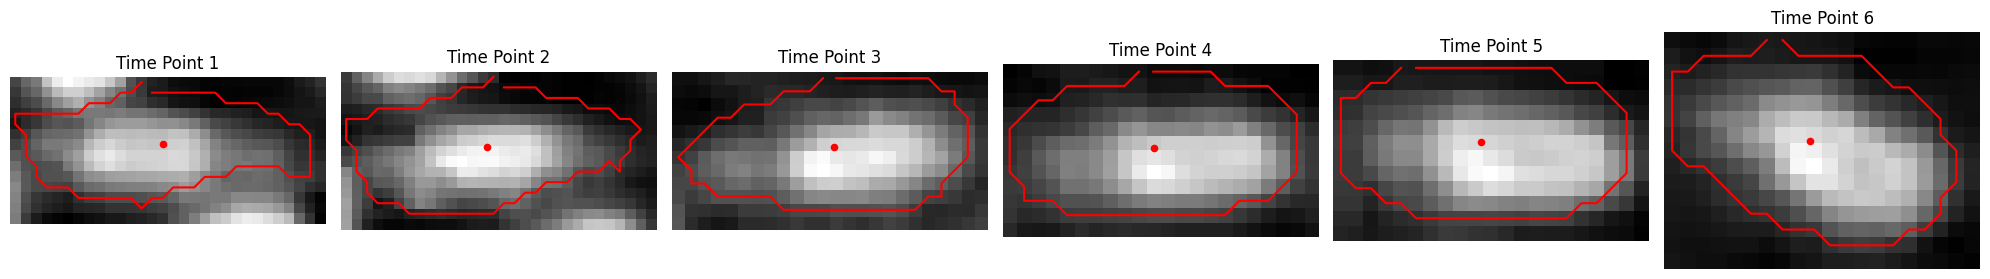

[(497, 135, 527, 149),
 (497, 135, 527, 150),
 (497, 138, 521, 150),
 (496, 139, 518, 151),
 (494, 140, 515, 152),
 (490, 138, 510, 153)]

In [45]:
initial_cell_index=100
n_times=6
check_index=0
cell_index_entire=compute_cell_index_entire(cell_center,check_index,initial_cell_index,n_times-1)
#plot_boundary_multiple(cell_center,outlines_list,check_index, cell_index_entire, n_times)
plot_boundary_multiple_time(cell_center,outlines_list,check_index,cell_index_entire,n_times)
process_and_overlay_images(image_matrices, outlines_list, cell_center, cell_index_entire, check_index, n_times)

## 5.Plot the boundary of a particular cell over the entire time period and add the true image

In [43]:
def process_and_overlay_images_select_region(image_matrices, outlines_list, cell_center, cell_index_entire, check_index, n):
    # Step 1: Get bounding rectangles
    bounding_rectangles = []
    for i in range(n):
        current_check_index = check_index + i
        if current_check_index < len(outlines_list):
            cell_index = cell_index_entire[current_check_index]
            cell_boundary = outlines_list[current_check_index][cell_index]
            min_x = min(cell_boundary[:, 0]) - 50
            max_x = max(cell_boundary[:, 0]) + 50
            min_y = min(cell_boundary[:, 1]) - 50
            max_y = max(cell_boundary[:, 1]) + 50
            bounding_rectangles.append((min_x, min_y, max_x, max_y))

    # Step 2: Crop images
    cropped_images = []
    for image_matrix, (min_x, min_y, max_x, max_y) in zip(image_matrices, bounding_rectangles):
        min_x, min_y, max_x, max_y = map(int, [min_x, min_y, max_x, max_y])
        min_x = max(min_x, 0)
        min_y = max(min_y, 0)
        max_x = min(max_x, image_matrix.shape[1])
        max_y = min(max_y, image_matrix.shape[0])
        cropped_image = image_matrix[min_y:max_y, min_x:max_x]
        cropped_images.append(cropped_image)

    # Step 3: Overlay boundaries
    cell_boundary_entire=[]
    cell_center_coords_entire=[]
    fig, axes = plt.subplots(int(n/2), 2, figsize=(30, 30))
    axes = axes.flatten()
    for i in range(n):
        ax = axes[i]
        current_check_index = check_index + i

        if current_check_index < len(outlines_list):
            cropped_image = cropped_images[i]
            ax.imshow(cropped_image, cmap='gray')

            cell_index = cell_index_entire[current_check_index]
            cell_boundary = outlines_list[current_check_index][cell_index]
            cell_center_coords = cell_center[current_check_index][cell_index]
            cell_boundary_entire.append(cell_boundary)
            cell_center_coords_entire.append(cell_center_coords)
            bounding_box = bounding_rectangles[i]
            shifted_boundary_x = cell_boundary[:, 0] - bounding_box[0] - 1
            shifted_boundary_y = cell_boundary[:, 1] - bounding_box[1] - 1
            shifted_center_x = cell_center_coords[0] - bounding_box[0] - 1
            shifted_center_y = cell_center_coords[1] - bounding_box[1] - 1

            ax.plot(shifted_boundary_x, shifted_boundary_y, color='red')
            ax.scatter(shifted_center_x, shifted_center_y, color='red', marker='o', s=20)

            ax.set_title(f'Time Point {current_check_index + 1}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

    return cell_boundary_entire,cell_center_coords_entire


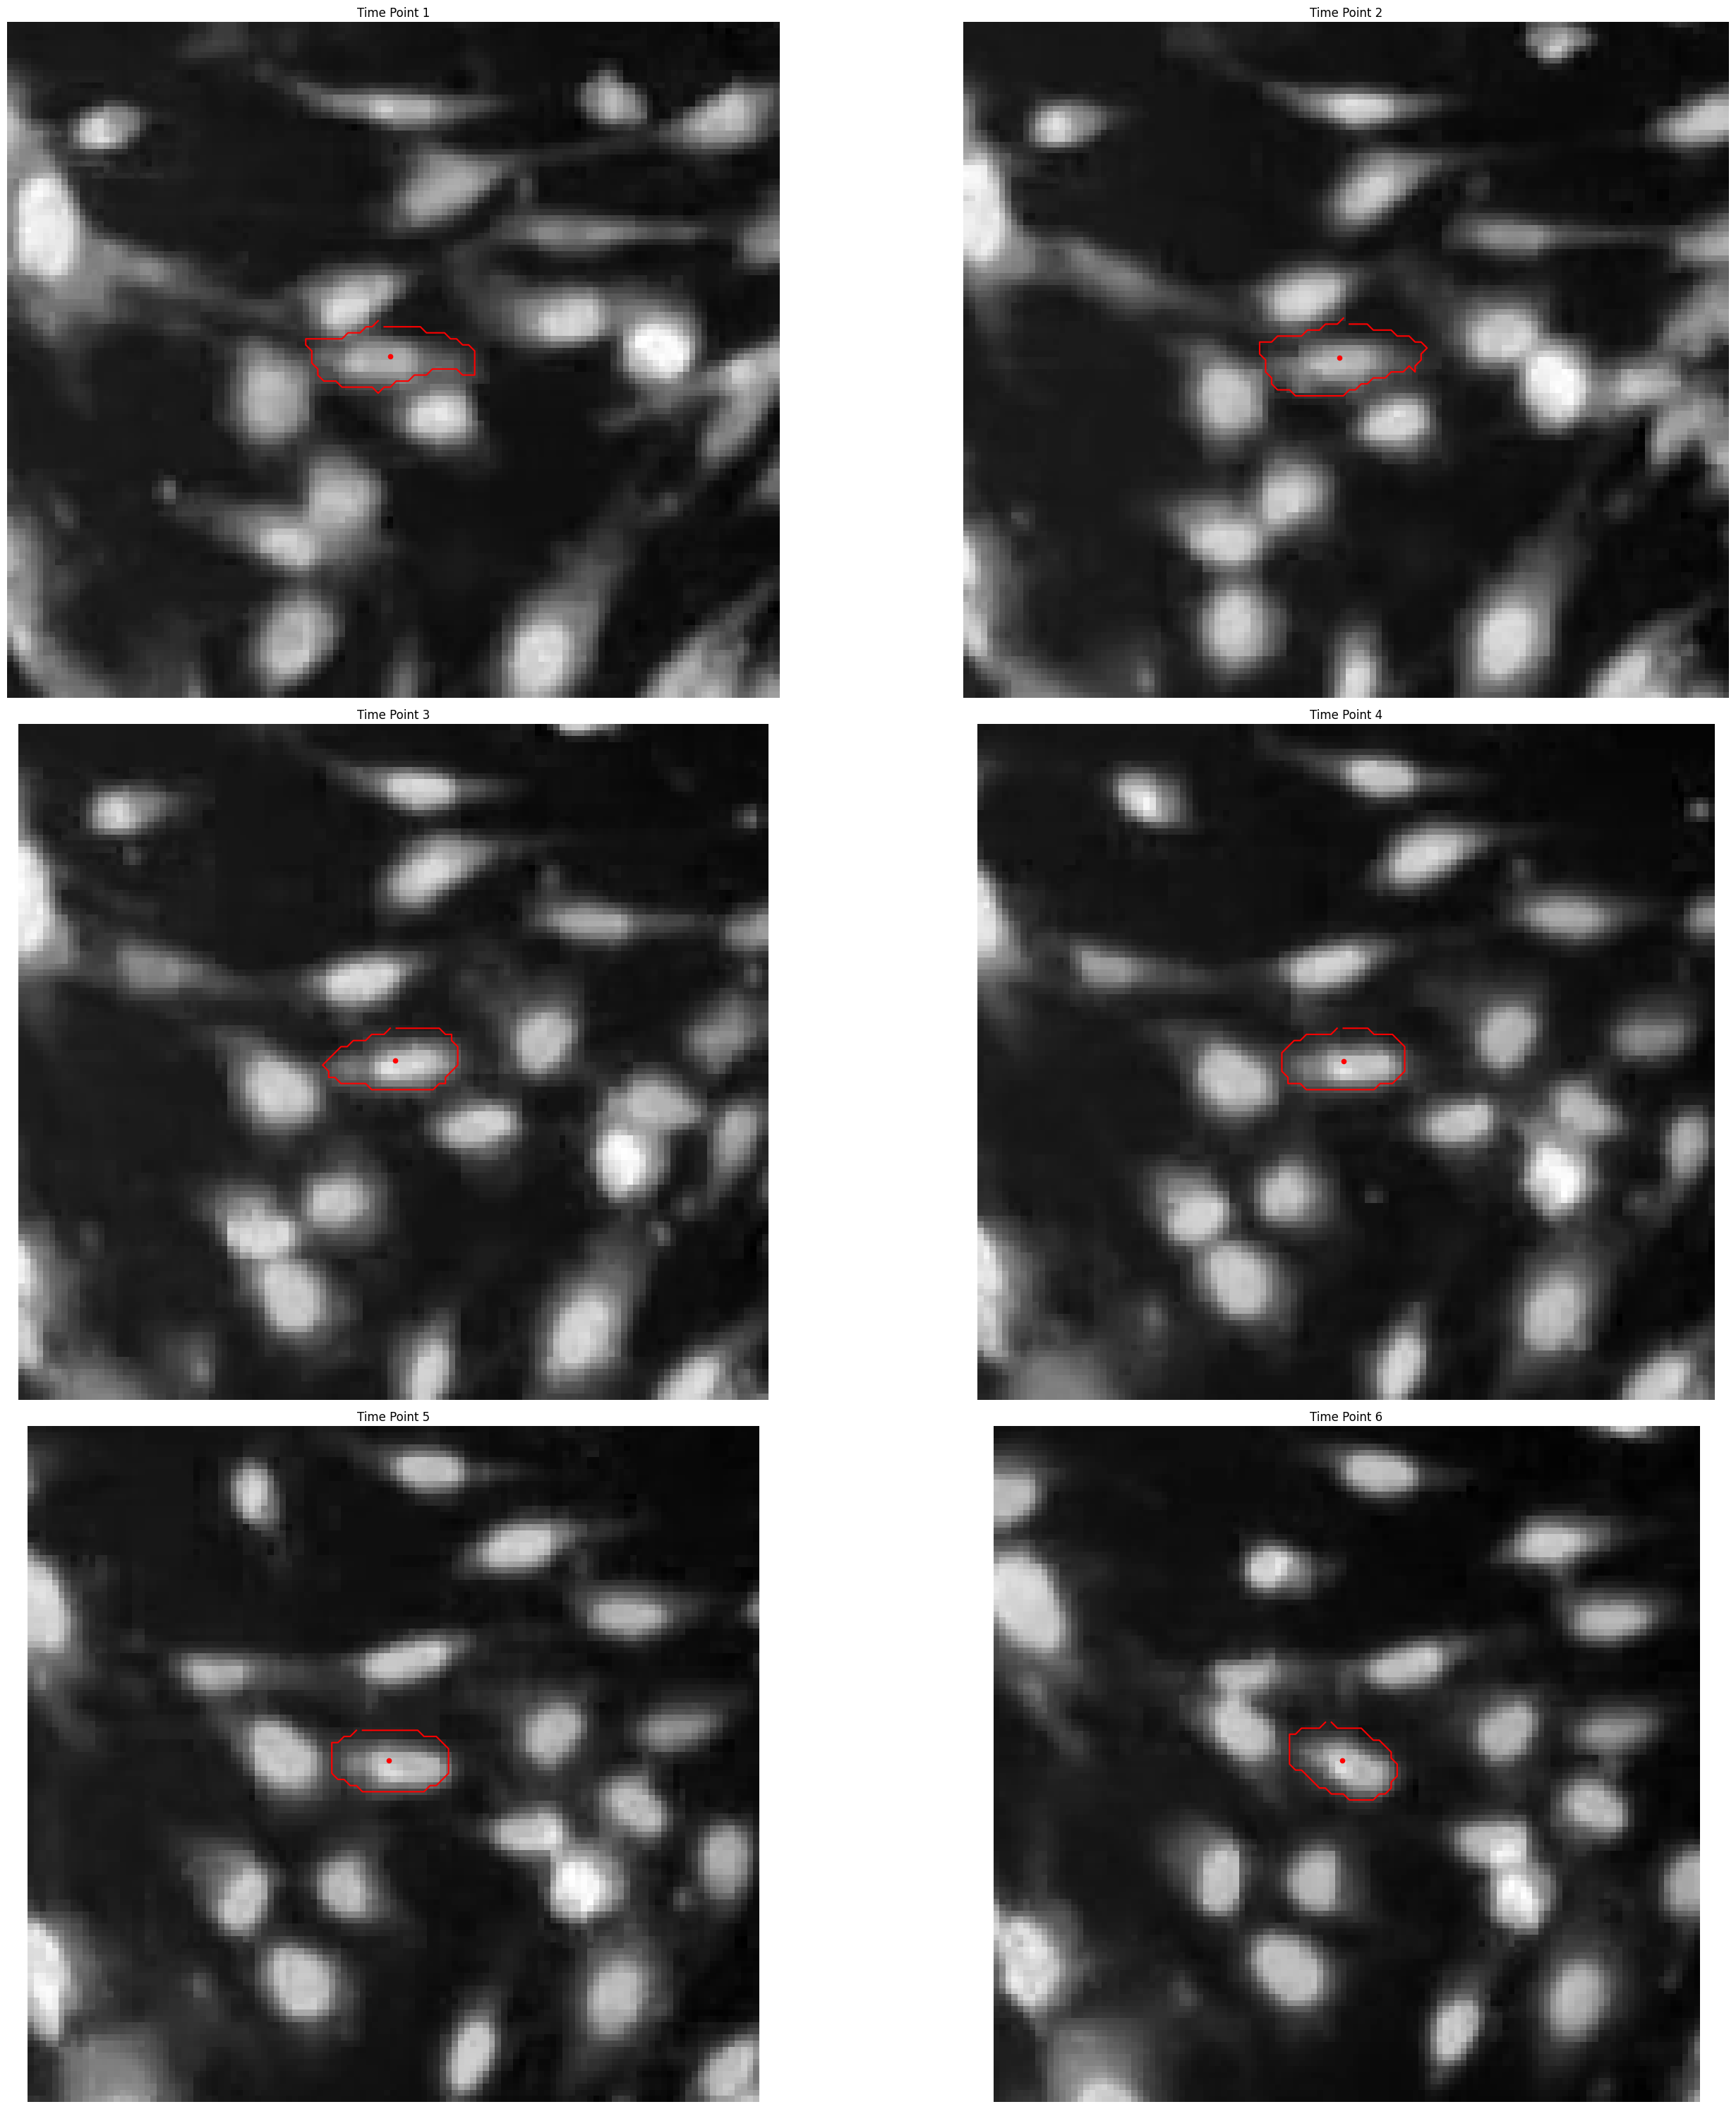

In [44]:
initial_cell_index=100
n_times=6
check_index=0
cell_index_entire=compute_cell_index_entire(cell_center,check_index,initial_cell_index,n_times-1)
cell_boundary_entire,cell_center_coords_entire=process_and_overlay_images_select_region(image_matrices, outlines_list, cell_center, cell_index_entire, check_index, n_times)

In [47]:
cell_index_entire=compute_cell_index_entire(cell_center,check_index,initial_cell_index,n_times-1)

In [48]:
# Convert each array into a list of string representations of coordinate pairs
str_coordinates = []
for array in cell_boundary_entire:
    str_coordinates.append(["{},{}".format(point[0], point[1]) for point in array])

# Create column names based on the number of arrays
column_names = ['frame{}'.format(i+1) for i in range(len(str_coordinates))]

# Transform into a DataFrame so that each array becomes a column
df = pd.DataFrame(str_coordinates).transpose()

# Assign column names
df.columns = column_names

# Write to a CSV file, if arrays are of different lengths, the shorter ones will have NaNs
df.to_csv('output.csv', index=False)  # Now the header parameter is omitted to include the column names
